In [346]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")

# Реализуем полностью нашу собственную модель линейной регрессии с регуляризацией

In [123]:
from sklearn.base import BaseEstimator, RegressorMixin

class RidgeWithReg(BaseEstimator, RegressorMixin):
    
    def __init__(self, batch_size=25, num_steps=350, lr=1e-2, lambd=1):
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.lr = lr
        self.lambd = lambd

    def fit(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)

        for i in range(self.num_steps):
            sample_indices = np.random.randint(0, n_objects, size=batch_size)
            w -= 2 * self.lr * np.dot(X[sample_indices].T, np.dot(X[sample_indices], w) - Y[sample_indices]) /\
                 self.batch_size + (2 * self.lambd / n_objects) * w

        self.w = w
        return self

    def predict(self, X):
        return X@self.w

In [124]:
class RidgeWithoutReg(BaseEstimator, RegressorMixin):
    
    def __init__(self, batch_size=25, num_steps=350, lr=1e-2):
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.lr = lr

    def fit(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)

        for i in range(self.num_steps):
            sample_indices = np.random.randint(0, n_objects, size=batch_size)
            w -= 2 * self.lr * np.dot(X[sample_indices].T, np.dot(X[sample_indices], w) - Y[sample_indices]) / self.batch_size

        self.w = w
        return self

    def predict(self, X):
        return X@self.w

# Сравним с моделью из коробки и с обычной регрессией

In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

#Генерация данных для тестирования
n_features = 700
n_objects = 100000

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features)) * np.arange(n_features)
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

In [131]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [132]:
scaler = StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

Сравним модели по $R^2 score$.

<p style="text-align: center;">$R^2 = 1 - \dfrac{\sum\limits_{i}(y_i - f(x_i, \omega))^2}{\sum\limits_{i}(y_i - y_{mean})^2}$</p>

$R^2 score$ показывает насколько наша модель хорошо описывает данные

In [133]:
own_model = RidgeWithoutReg().fit(x_scaled, y_train)
own_model_reg = RidgeWithReg().fit(x_scaled, y_train)
y_pred = own_model.predict(x_test_scaled)
y_pred_reg = own_model_reg.predict(x_test_scaled)
own_r2 = r2_score(y_test, y_pred)
own_r2_reg = r2_score(y_test, y_pred_reg)

sklearn_model = LinearRegression().fit(x_scaled, y_train)
y_pred = sklearn_model.predict(x_test_scaled)
sklearn_r2 = r2_score(y_test, y_pred)

print('R^2 in own model without regularization:', own_r2)
print('R^2 in own model with regularization:', own_r2_reg)
print('R^2 in sklearn loss:', sklearn_r2)

R^2 in own model without regularization: 0.9803713225857945
R^2 in own model with regularization: 0.9835130721972706
R^2 in sklearn loss: 0.999999999790781


Видим, что наша модель с регуляризацией действительно показывает себя лучше. Кроме того, прибавка $lambd * w$ как никак полезна для избавления от вырожденности матрицы, от которой мы берем обратную, что помогает при вычислении весов формулой. Регуляризация это крута (сильно хуже $score$ не станет, а помочь может)!

# Логистическая регрессия

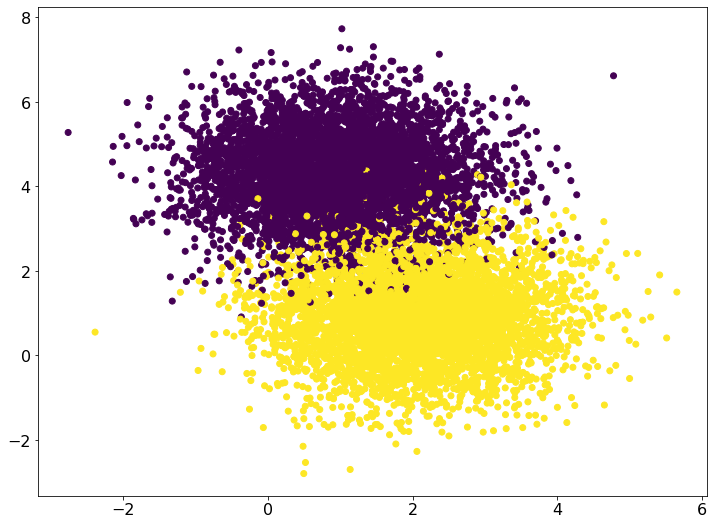

In [571]:
X, y = make_blobs(n_samples=10000, centers=2, n_features=2, random_state=0)
plt.figure(figsize=(12, 9))
plt.scatter(x=X[:, 0], y=X[:, 1],c=y)
plt.show()

In [572]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [577]:
class LogReg():
    
    def __init__(self, num_steps=350, lr=1e-2):
        self.num_steps = num_steps
        self.lr = lr

    def fit(self, X, Y):
        self.first_label = Y[0]
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)
        Y = Y.reshape(-1, 1)

        for i in range(self.num_steps):
            preds = X @ w 
            probs = sigmoid(preds)
            w -= self.lr * -(np.dot(X.T, Y - probs))

        self.w = w
        return self

    def predict(self, X, thresh=0.5):
        probs = sigmoid(X @ self.w)
        return [1 if prob > thresh else 0 for prob in probs] 

In [578]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

In [579]:
scaler = StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [580]:
from sklearn.metrics import accuracy_score

own_model = LogReg().fit(x_scaled, y_train)
y_pred = own_model.predict(x_test_scaled)
own_acc = accuracy_score(y_test, y_pred)

sklearn_log_reg = LogisticRegression().fit(x_scaled, y_train)
y_pred = sklearn_log_reg.predict(x_test_scaled)
sklearn_acc = accuracy_score(y_test, y_pred)

print('Точность нашей модели:', own_acc)
print('Точность модели sklearn', sklearn_acc)

Точность нашей модели: 0.962
Точность модели sklearn 0.9612


Наша модель показывает $\pm$ такую же точность, как и модель из коробки. Ура! (Протестировано и на большем числе n_features)